# **1. Setup data:**

In [1]:
# download data: FPT_train
# FPT_train
!gdown --id 1l2TtEaWrp4yieMDWE4Cmehnf5mLx3rop

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1l2TtEaWrp4yieMDWE4Cmehnf5mLx3rop
To: d:\CODE\Machine-Learning-Deep-Learning-2025\AIO2025 - Mein Code\Module6\project\FPT_train.csv

  0%|          | 0.00/55.3k [00:00<?, ?B/s]
100%|██████████| 55.3k/55.3k [00:00<00:00, 1.77MB/s]


# **2. Code**

In [2]:
# ============================================================
# FPT Forecast : Hybrid + Pricing
#
#  - Data:
#       * FPT_train.csv:  FPT OHLCV
#
#  - Pipeline:
#       1) FE: STL + OHLCV + patterns
#       2) Math backbone (trend trên log(close)):
#           - future_ret_math = trend_log_{t+1} - trend_log_t
#       3) ML residual:
#           - XGB học residual: resid_ret = future_ret_real - future_ret_math
#           - future_ret_final = future_ret_math_forecast + xgb_resid_pred
#       4) Hybrid raw path:
#           - build_raw_base_path_hybrid() H=100 ngày (recursive)
#       5) Pricing-layer (regime-aware, pure FPT):
#           - Clip return theo history, half-life damping, mean-revert quanh MA60
#           - Regime BULL/BEAR/SIDEWAYS từ FPT:
#               * price vs MA120
#               * vol_20 vs vol_all
#           - Random search trên pricing params:
#               * Multi-cutoff CV (2020–2024, tháng 3/6/9/12)
#               * Metric = 0.5 * MSE_50 + 0.5 * MSE_100
#       6) FINAL MODEL:
#           - Train XGB residual trên full FPT_train
#           - Hybrid raw path H=100 ngày
#           - Áp pricing-best để ra BASE path
#           - TREND (linear price), UNCERT analytic, MC band
#
#  - Outputs:
#       * FPT_forecast.csv
#       * submission.csv (id, close = central_det)
#
#  NOTE:
#       - Pricing-layer được chọn bằng time-series CV trên chính FPT_train.
# ============================================================

## **2.0. IMPORT & GLOBAL CONFIG**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random
from dataclasses import dataclass
from typing import List, Optional, Tuple

from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import BDay

warnings.filterwarnings("ignore")

In [27]:
SEED = 98
random.seed(SEED)
np.random.seed(SEED)

FPT_TRAIN_PATH = "FPT_train.csv"

FORCE_TRAIN_END_DATE = None

TOTAL_PREDICT_DAYS = 100  # horizon chính khi forecast
HORIZON = 1               # future_ret = T+1
STL_PERIOD = 20           # ~1 tháng giao dịch

# Uncertainty band (analytic)
UNCERT_Z = 1.28155        # ~90% interval

# CV config
CV_START_YEAR = 2020
CV_END_YEAR = 2024
CV_HORIZON = 100          # forecast H ngày trong CV (same as competition horizon)
N_RANDOM_TRIALS = 120     # số cấu hình pricing-layer thử

# Monte Carlo config
N_MC_PATHS = 500          # số path để sinh MC band

## **2.1. FEATURE ENGINEERING**

In [5]:
def add_stl_ohlcv_features(df_raw: pd.DataFrame, stl_period: int = STL_PERIOD) -> pd.DataFrame:
    """
    FE cho FPT OHLCV:
        - close_log
        - Price action OHLC: body, range, shadows, gaps, range_pct, ATR, Parkinson
        - Volume & money flow
        - STL trend/seasonal/resid
        - Returns: ret_1d, ret_5d, ret_10d
        - Patterns: up/down, 3-streak
        - Trend slopes, accel, rolling stats, z-score
    """
    df = df_raw.copy()
    if "close" not in df.columns:
        raise ValueError("DataFrame phải có cột 'close'.")

    df["close"] = df["close"].astype(float)
    df["close_log"] = np.log(df["close"] + 1e-8)
    eps = 1e-6

    # --- Price action từ OHLC ---
    has_ohlc = all(c in df.columns for c in ["open", "high", "low"])
    pa_cols = [
        "body",
        "range",
        "upper_shadow",
        "lower_shadow",
        "body_rel",
        "close_pos",
        "gap_oc",
        "gap_prev_close",
        "range_pct",
        "true_range",
        "atr_14",
        "park_vol",
        "range_ma_10",
        "range_expansion",
        "body_lag1",
        "body_lag2",
        "close_pos_lag1",
    ]
    if has_ohlc:
        df["open"] = df["open"].astype(float)
        df["high"] = df["high"].astype(float)
        df["low"] = df["low"].astype(float)

        df["body"] = df["close"] - df["open"]
        df["range"] = df["high"] - df["low"]
        df["body_rel"] = df["body"] / (df["range"].abs() + eps)

        df["upper_shadow"] = df["high"] - df[["open", "close"]].max(axis=1)
        df["lower_shadow"] = df[["open", "close"]].min(axis=1) - df["low"]
        df["close_pos"] = (df["close"] - df["low"]) / (df["range"].abs() + eps)

        df["gap_oc"] = df["open"] - df["close"]
        df["gap_prev_close"] = df["open"] - df["close"].shift(1)

        prev_close = df["close"].shift(1)
        df["range_pct"] = df["range"] / (prev_close.abs() + eps)

        tr1 = (df["high"] - df["low"]).abs()
        tr2 = (df["high"] - prev_close).abs()
        tr3 = (df["low"] - prev_close).abs()
        df["true_range"] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        df["atr_14"] = df["true_range"].rolling(14).mean()

        ratio_hl = (df["high"] / (df["low"] + eps)).clip(lower=eps)
        df["park_vol"] = (1.0 / (4.0 * np.log(2.0))) * (np.log(ratio_hl) ** 2)

        df["range_ma_10"] = df["range"].rolling(10).mean()
        df["range_expansion"] = (df["range"] > 1.5 * (df["range_ma_10"].abs() + eps)).astype(float)

        df["body_lag1"] = df["body"].shift(1)
        df["body_lag2"] = df["body"].shift(2)
        df["close_pos_lag1"] = df["close_pos"].shift(1)
    else:
        for c in pa_cols:
            df[c] = 0.0

    # --- Volume & money flow ---
    vol_cols = [
        "volume",
        "vol_ma_5",
        "vol_ma_20",
        "vol_ratio",
        "money_flow",
        "money_flow_5",
        "vol_z_20",
        "obv",
        "vol_ratio_lag1",
        "obv_diff_1d",
    ]
    if "volume" in df.columns:
        df["volume"] = df["volume"].astype(float)
        df["vol_ma_5"] = df["volume"].rolling(5).mean()
        df["vol_ma_20"] = df["volume"].rolling(20).mean()
        df["vol_ratio"] = df["volume"] / (df["vol_ma_20"].abs() + eps)
        df["money_flow"] = df["close"] * df["volume"]
        df["money_flow_5"] = df["money_flow"].rolling(5).mean()
        df["vol_z_20"] = (df["volume"] - df["vol_ma_20"]) / (df["vol_ma_20"].abs() + eps)

        sign = np.sign(df["close"].diff(1))
        df["obv"] = (sign * df["volume"]).fillna(0).cumsum()

        df["vol_ratio_lag1"] = df["vol_ratio"].shift(1)
        df["obv_diff_1d"] = df["obv"].diff(1)
    else:
        for c in vol_cols:
            df[c] = 0.0

    # --- STL trên close_log ---
    close_log = df["close_log"].copy()
    if close_log.isna().any():
        close_log = close_log.fillna(method="ffill").fillna(method="bfill")

    res = STL(close_log.values, period=stl_period, robust=True).fit()
    df["trend_stl"] = res.trend
    df["seasonal_stl"] = res.seasonal
    df["resid_stl"] = res.resid

    # --- Returns ---
    df["ret_1d"] = df["close_log"].diff(1)
    df["ret_5d"] = df["close_log"].diff(5)
    df["ret_10d"] = df["close_log"].diff(10)

    # --- Patterns ---
    df["up_1d"] = (df["ret_1d"] > 0).astype(float)
    df["down_1d"] = (df["ret_1d"] < 0).astype(float)
    df["up_3streak"] = (
        (df["ret_1d"] > 0)
        & (df["ret_1d"].shift(1) > 0)
        & (df["ret_1d"].shift(2) > 0)
    ).astype(float)
    df["down_3streak"] = (
        (df["ret_1d"] < 0)
        & (df["ret_1d"].shift(1) < 0)
        & (df["ret_1d"].shift(2) < 0)
    ).astype(float)

    # --- Trend slopes & stats ---
    df["trend_slope_1"] = df["trend_stl"].diff(1)
    df["trend_slope_3"] = df["trend_stl"].diff(3)
    df["trend_slope_7"] = df["trend_stl"].diff(7)

    df["trend_accel_3"] = df["trend_slope_1"] - df["trend_slope_1"].shift(3)

    df["trend_mean_21"] = df["trend_stl"].rolling(21).mean()
    df["trend_std_21"] = df["trend_stl"].rolling(21).std(ddof=0)
    df["resid_std_10"] = df["resid_stl"].rolling(10).std(ddof=0)
    df["resid_std_20"] = df["resid_stl"].rolling(20).std(ddof=0)

    df["z_trend_21"] = (df["trend_stl"] - df["trend_mean_21"]) / (df["trend_std_21"] + eps)

    return df


def get_feature_cols() -> List[str]:
    base_cols = [
        "close_log",
        "ret_1d",
        "ret_5d",
        "ret_10d",
        "up_1d",
        "down_1d",
        "up_3streak",
        "down_3streak",
        "trend_stl",
        "trend_slope_1",
        "trend_slope_3",
        "trend_slope_7",
        "trend_accel_3",
        "trend_mean_21",
        "trend_std_21",
        "resid_std_10",
        "resid_std_20",
        "z_trend_21",
        "body",
        "range",
        "upper_shadow",
        "lower_shadow",
        "body_rel",
        "close_pos",
        "gap_oc",
        "gap_prev_close",
        "range_pct",
        "range_ma_10",
        "range_expansion",
        "body_lag1",
        "body_lag2",
        "close_pos_lag1",
        "true_range",
        "atr_14",
        "park_vol",
        "volume",
        "vol_ma_5",
        "vol_ma_20",
        "vol_ratio",
        "vol_ratio_lag1",
        "money_flow",
        "money_flow_5",
        "vol_z_20",
        "obv",
        "obv_diff_1d",
    ]
    return base_cols


def build_modeling_df(
    df_slice: pd.DataFrame,
    stl_period: int,
    horizon: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Build FE + target trên một slice thời gian (vd: <= cutoff).
    - future_ret: log(P_{t+h}) - log(P_t)
    - math_ret:   trend_log_{t+h} - trend_log_t (linear trend trên log-price)
    - resid_ret:  future_ret - math_ret  (target cho XGB residual)
    """
    df_slice = df_slice.sort_values("time").reset_index(drop=True)
    df_feat = add_stl_ohlcv_features(df_slice, stl_period=stl_period)
    feature_cols = get_feature_cols()

    # target future_ret
    df_feat["time_future"] = df_feat["time"].shift(-horizon)
    df_feat["close_log_future"] = df_feat["close_log"].shift(-horizon)
    df_feat["future_ret"] = df_feat["close_log_future"] - df_feat["close_log"]

    # Math backbone: linear trend trên log-price
    time_idx = np.arange(len(df_feat)).reshape(-1, 1)
    y_log = df_feat["close_log"].values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(time_idx, y_log)
    trend_log = lr.predict(time_idx).flatten()
    df_feat["trend_log"] = trend_log
    df_feat["trend_log_future"] = df_feat["trend_log"].shift(-horizon)
    df_feat["math_ret"] = df_feat["trend_log_future"] - df_feat["trend_log"]

    # Residual target
    df_feat["resid_ret"] = df_feat["future_ret"] - df_feat["math_ret"]

    # Modeling DF: drop rows thiếu
    df_model = df_feat.dropna(
        subset=feature_cols + ["future_ret", "math_ret", "resid_ret", "time_future"]
    ).reset_index(drop=True)

    print("Modeling DF shape:", df_model.shape)
    return df_feat, df_model, feature_cols

## **2.2. MODEL STRUCTS**

In [6]:
@dataclass
class CutoffModel:
    cutoff_time: pd.Timestamp
    xgb: XGBRegressor
    scaler_X: StandardScaler
    feature_cols: List[str]
    df_hist: pd.DataFrame          # OHLCV <= cutoff
    df_feat: pd.DataFrame          # FE <= cutoff
    raw_base_prices_cv: np.ndarray # raw base path hybrid cho CV_HORIZON
    raw_base_rets_cv: np.ndarray   # hybrid future_ret path cho CV_HORIZON


@dataclass
class PricingParams:
    ret_clip_quantile: float
    half_life_days: int
    mean_revert_alpha: float
    mean_revert_start: int
    fair_up_mult: float
    fair_down_mult: float
    trend_lookback: int
    trend_ret_thresh: float


@dataclass
class FinalBaseModel:
    xgb: XGBRegressor
    scaler_X: StandardScaler
    feature_cols: List[str]
    df_train: pd.DataFrame      # OHLCV train (pure FPT)
    df_feat: pd.DataFrame       # FE train
    train_end_date: pd.Timestamp
    resid_std: float
    resid_mean: float

## **2.3. TRAIN XGB RESIDUAL**

In [7]:
def train_xgb_on_dfmodel(df_model: pd.DataFrame, feature_cols: List[str]) -> Tuple[XGBRegressor, StandardScaler, float, float]:
    """
    Train XGB trên resid_ret = future_ret - math_ret.
    """
    if len(df_model) < 200:
        raise ValueError(f"[XGB] Too few samples: {len(df_model)}")

    X_all = df_model[feature_cols].values.astype(np.float32)
    y_resid = df_model["resid_ret"].values.astype(np.float32)

    N = len(df_model)
    train_ratio = 0.8
    val_ratio = 0.1

    train_end = int(N * train_ratio)
    val_end = int(N * (train_ratio + val_ratio))

    X_train = X_all[:train_end]
    y_train = y_resid[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_resid[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_resid[val_end:]

    scaler_X = StandardScaler().fit(X_train)
    X_train_s = scaler_X.transform(X_train)
    X_val_s = scaler_X.transform(X_val)
    X_test_s = scaler_X.transform(X_test)

    xgb = XGBRegressor(
        n_estimators=450,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=2.0,
        min_child_weight=3,
        objective="reg:squarederror",
        random_state=SEED,
    )
    xgb.fit(X_train_s, y_train)

    def eval_block(name, X_s, y_true):
        if len(y_true) == 0:
            print(f"{name}: empty")
            return
        y_pred = xgb.predict(X_s)
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        print(f"{name} (resid) -> MSE: {mse:.6e} | MAE: {mae:.6e}")

    print(f"=== XGB RESIDUAL MODEL ({len(df_model)} samples) ===")
    eval_block("Train", X_train_s, y_train)
    eval_block("Val", X_val_s, y_val)
    eval_block("Test", X_test_s, y_test)

    # residuals full để tính sigma / mean
    y_pred_all = xgb.predict(scaler_X.transform(X_all))
    residuals = y_resid - y_pred_all
    resid_std = float(np.std(residuals, ddof=1))
    resid_mean = float(np.mean(residuals))

    print(f"[RESID] std={resid_std:.6e}, mean={resid_mean:.6e}")
    return xgb, scaler_X, resid_std, resid_mean

## **2.4. RAW BASE PATH HYBRID (MATH + ML RESIDUAL)**

In [8]:
def build_raw_base_path_hybrid(
    df_hist: pd.DataFrame,
    xgb: XGBRegressor,
    scaler_X: StandardScaler,
    feature_cols: List[str],
    total_days: int,
    stl_period: int = STL_PERIOD,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Chạy recursive hybrid:
      - Math backbone: linear trend trên log-price (fit trên df_hist ban đầu)
      - XGB: dự đoán residual (resid_ret)
      - future_ret_final = math_ret_forecast + resid_pred

    Trả về:
      - raw_base_prices: giá future nếu chỉ dùng hybrid
      - raw_base_rets:   future_ret_final (log-return) mỗi bước
    """
    df_state = df_hist.sort_values("time").reset_index(drop=True).copy()
    df_state["close"] = df_state["close"].astype(float)
    df_state["close_log"] = np.log(df_state["close"] + 1e-8)

    # Fit math backbone (trend) trên df_hist ban đầu
    N_hist = len(df_state)
    time_idx_hist = np.arange(N_hist).reshape(-1, 1)
    y_log_hist = df_state["close_log"].values.reshape(-1, 1)
    lr_trend = LinearRegression()
    lr_trend.fit(time_idx_hist, y_log_hist)

    # Extend trend cho tương lai
    total_len = N_hist + total_days
    time_idx_full = np.arange(total_len).reshape(-1, 1)
    trend_log_full = lr_trend.predict(time_idx_full).flatten()

    # Precompute math_ret_forecast cho từng bước
    math_rets_forecast = np.zeros(total_days, dtype=float)
    for k in range(total_days):
        base_idx = N_hist - 1 + k
        if base_idx + 1 < len(trend_log_full):
            math_rets_forecast[k] = trend_log_full[base_idx + 1] - trend_log_full[base_idx]
        else:
            math_rets_forecast[k] = math_rets_forecast[k - 1] if k > 0 else 0.0

    raw_prices: List[float] = []
    raw_rets: List[float] = []

    for step_idx in range(total_days):
        last_close = df_state["close"].iloc[-1]
        last_time = df_state["time"].iloc[-1]

        new_row = {"time": last_time + BDay(1), "close": last_close}
        if "volume" in df_state.columns:
            new_row["volume"] = df_state["volume"].iloc[-1]
        if all(c in df_state.columns for c in ["open", "high", "low"]):
            new_row["open"] = last_close
            new_row["high"] = last_close
            new_row["low"] = last_close

        df_state = pd.concat([df_state, pd.DataFrame([new_row])], ignore_index=True)
        df_state["close"] = df_state["close"].astype(float)
        df_state["close_log"] = np.log(df_state["close"] + 1e-8)

        df_state_feat = add_stl_ohlcv_features(df_state, stl_period=stl_period)
        last_row = df_state_feat.iloc[-1]
        feat_vals = []
        for col in feature_cols:
            v = last_row.get(col, np.nan)
            if pd.isna(v):
                v = 0.0
            feat_vals.append(v)

        X_last = np.array(feat_vals, dtype=np.float32).reshape(1, -1)
        X_last_s = scaler_X.transform(X_last)
        resid_pred = float(xgb.predict(X_last_s)[0])

        math_ret = float(math_rets_forecast[step_idx])
        final_ret = math_ret + resid_pred  # hybrid

        last_log = df_state["close_log"].iloc[-2]
        next_log = last_log + final_ret
        next_price = float(np.exp(next_log))

        last_idx = df_state.index[-1]
        df_state.at[last_idx, "close"] = next_price
        df_state.at[last_idx, "close_log"] = np.log(next_price + 1e-8)
        if all(c in df_state.columns for c in ["open", "high", "low"]):
            df_state.at[last_idx, "open"] = next_price
            df_state.at[last_idx, "high"] = next_price
            df_state.at[last_idx, "low"] = next_price

        raw_prices.append(next_price)
        raw_rets.append(final_ret)

    return np.array(raw_prices, dtype=float), np.array(raw_rets, dtype=float)

##**2.5. REGIME DETECTOR**

In [9]:
def detect_regime(hist_close: np.ndarray, df_feat_hist: pd.DataFrame) -> str:
    """
    Phân loại chế độ thị trường:
      - BULL: giá trên MA120 và vol_20 thấp hơn vol dài hạn
      - BEAR: giá dưới MA120 và vol_20 cao hơn vol dài hạn
      - SIDEWAYS: còn lại
    """
    price_series = pd.Series(hist_close.astype(float))
    if len(price_series) >= 120:
        ma_long = price_series.rolling(120).mean().iloc[-1]
    else:
        ma_long = price_series.mean()

    price_last = price_series.iloc[-1]
    price_pos = price_last / (ma_long + 1e-8) - 1.0  # % chênh lệch so với MA120

    ret_1d = df_feat_hist["ret_1d"].dropna()
    if len(ret_1d) < 30:
        return "SIDEWAYS"

    vol_20 = ret_1d.rolling(20).std().iloc[-1]
    vol_all = ret_1d.std()
    vol_ratio = vol_20 / (vol_all + 1e-8)

    if price_pos < -0.05 and vol_ratio > 1.2:
        regime = "BEAR"
    elif price_pos > 0.05 and vol_ratio < 0.8:
        regime = "BULL"
    else:
        regime = "SIDEWAYS"

    print(f"[REGIME] last_price={price_last:.2f}, MA120={ma_long:.2f}, "
          f"price_pos={price_pos*100:.2f}%, vol_ratio={vol_ratio:.2f} -> {regime}")

    return regime

##**2.6. PRICING LAYER**

In [10]:
def apply_pricing_on_raw_path(
    hist_close: np.ndarray,
    df_feat_hist: pd.DataFrame,
    raw_rets: np.ndarray,
    pricing: PricingParams,
) -> np.ndarray:
    """
    Áp pricing-layer lên chuỗi raw_rets hybrid:
      - Clip ret theo quantile trên |ret_1d| history, scale theo vol & regime
      - Damping bằng half-life, scale theo regime
      - Mean-revert quanh fair_level (MA60) với gating theo trend dài hạn & regime
    """
    total_days = len(raw_rets)

    FAIR_MA_LEN = 60
    if len(hist_close) >= FAIR_MA_LEN:
        fair_level = float(hist_close[-FAIR_MA_LEN:].mean())
    else:
        fair_level = float(hist_close.mean())

    hist_abs_ret = df_feat_hist["ret_1d"].dropna().abs()
    if len(hist_abs_ret) == 0:
        base_ret_clip = 0.05
    else:
        base_ret_clip = float(hist_abs_ret.quantile(pricing.ret_clip_quantile))

    ret_1d = df_feat_hist["ret_1d"].dropna()
    if len(ret_1d) >= 30:
        vol_20 = ret_1d.rolling(20).std().iloc[-1]
        vol_all = ret_1d.std()
        vol_ratio = vol_20 / (vol_all + 1e-8)
    else:
        vol_ratio = 1.0

    regime = detect_regime(hist_close, df_feat_hist)

    # Regime-based scaling
    if regime == "BULL":
        clip_scale_regime = 1.2
        mr_alpha_scale_regime = 0.7
        damp_scale_regime = 0.85
        up_mult_scale_regime = 1.05
        down_mult_scale_regime = 1.0
    elif regime == "BEAR":
        clip_scale_regime = 0.95
        mr_alpha_scale_regime = 1.25
        damp_scale_regime = 1.15
        up_mult_scale_regime = 0.95
        down_mult_scale_regime = 0.95
    else:  # SIDEWAYS
        clip_scale_regime = 1.0
        mr_alpha_scale_regime = 1.0
        damp_scale_regime = 1.0
        up_mult_scale_regime = 1.0
        down_mult_scale_regime = 1.0

    clip_scale_vol = float(np.clip(vol_ratio, 0.8, 1.2))

    ret_clip = base_ret_clip * clip_scale_regime * clip_scale_vol
    ret_clip = float(np.clip(ret_clip, 0.01, 0.15))

    lambda_damp = np.log(2.0) / float(max(int(pricing.half_life_days * damp_scale_regime), 1))

    alpha_base = pricing.mean_revert_alpha * mr_alpha_scale_regime
    fair_up_mult = pricing.fair_up_mult * up_mult_scale_regime
    fair_down_mult = pricing.fair_down_mult * down_mult_scale_regime

    prices = np.empty(total_days, dtype=float)
    full_history = list(hist_close.astype(float))

    for step_idx in range(total_days):
        raw_ret = float(raw_rets[step_idx])

        # 1) Clip return
        pred_ret = np.clip(raw_ret, -ret_clip, ret_clip)

        # 2) Damping theo half-life
        scale = np.exp(-lambda_damp * step_idx)
        pred_ret *= scale

        # 3) Convert sang price
        last_price = full_history[-1]
        next_price = float(last_price * np.exp(pred_ret))

        # 4) Trend-based gating for mean-revert
        lookback = pricing.trend_lookback
        if len(full_history) > lookback:
            past_price = full_history[-lookback]
            current_price = full_history[-1]
            trend_ret = (current_price - past_price) / max(past_price, 1e-6)
        else:
            trend_ret = 0.0

        is_strong_uptrend = trend_ret > pricing.trend_ret_thresh
        is_strong_downtrend = trend_ret < -pricing.trend_ret_thresh

        # 5) Mean-revert quanh fair_level
        if step_idx >= pricing.mean_revert_start:
            upper = fair_level * fair_up_mult
            lower = fair_level * fair_down_mult

            if (next_price > upper) and (not is_strong_uptrend):
                alpha_up = alpha_base * (0.7 if regime == "BULL" else 1.0)
                next_price = (1 - alpha_up) * next_price + alpha_up * upper
            elif next_price < lower:
                if regime == "BEAR" and is_strong_downtrend:
                    alpha_down = alpha_base * 0.7
                else:
                    alpha_down = alpha_base
                next_price = (1 - alpha_down) * next_price + alpha_down * lower

        prices[step_idx] = next_price
        full_history.append(next_price)

    return prices

##**2.7. CV CUTOFF BUILDER**

In [11]:
def build_cv_cutoffs(
    df_train: pd.DataFrame,
    start_year: int,
    end_year: int,
    horizon_days: int,
) -> List[pd.Timestamp]:
    """
    Chọn cutoff: cuối các tháng [3, 6, 9, 12] mỗi năm trong [start_year, end_year],
    nhưng đảm bảo cutoff + horizon_days BDay vẫn nằm trong FPT_train.
    """
    df = df_train.sort_values("time").reset_index(drop=True)
    last_date = df["time"].max()
    cutoffs: List[pd.Timestamp] = []

    CUTOFF_MONTHS = [3, 6, 9, 12]

    for year in range(start_year, end_year + 1):
        df_year = df[df["time"].dt.year == year]
        if df_year.empty:
            continue
        for m in CUTOFF_MONTHS:
            df_month = df_year[df_year["time"].dt.month == m]
            if df_month.empty:
                continue
            candidate = df_month["time"].max()
            if candidate + BDay(horizon_days) <= last_date:
                cutoffs.append(candidate)

    cutoffs = sorted(list(set(cutoffs)))
    print("[CV] Cutoffs (multi-month, trong FPT_train):")
    for c in cutoffs:
        print(" -", c.date())
    return cutoffs

##**2.8. BUILD CUTOFF MODELS**

In [12]:
def build_cutoff_models(
    df_train: pd.DataFrame,
    cv_cutoffs: List[pd.Timestamp],
    stl_period: int,
    horizon: int,
) -> List[CutoffModel]:
    models: List[CutoffModel] = []
    for cutoff in cv_cutoffs:
        df_hist_cut = df_train[df_train["time"] <= cutoff].copy().reset_index(drop=True)
        if len(df_hist_cut) < 250:
            print(f"[CV] Skip cutoff {cutoff.date()} (not enough OHLCV history)")
            continue

        print(f"\n[CV] === Cutoff {cutoff.date()} ===")
        df_feat_cut, df_model_cut, feature_cols = build_modeling_df(
            df_hist_cut,
            stl_period=stl_period,
            horizon=horizon,
        )

        xgb, scaler_X, _, _ = train_xgb_on_dfmodel(df_model_cut, feature_cols)

        raw_prices_cv, raw_rets_cv = build_raw_base_path_hybrid(
            df_hist=df_hist_cut,
            xgb=xgb,
            scaler_X=scaler_X,
            feature_cols=feature_cols,
            total_days=CV_HORIZON,
            stl_period=stl_period,
        )

        models.append(
            CutoffModel(
                cutoff_time=cutoff,
                xgb=xgb,
                scaler_X=scaler_X,
                feature_cols=feature_cols,
                df_hist=df_hist_cut,
                df_feat=df_feat_cut,
                raw_base_prices_cv=raw_prices_cv,
                raw_base_rets_cv=raw_rets_cv,
            )
        )

    return models

##**2.9. RANDOM SEARCH SPACE**

In [13]:
def sample_pricing_params() -> PricingParams:
    return PricingParams(
        ret_clip_quantile=random.uniform(0.95, 0.995),
        half_life_days=random.randint(40, 120),
        mean_revert_alpha=random.uniform(0.02, 0.10),
        mean_revert_start=random.randint(25, 65),
        fair_up_mult=random.uniform(1.25, 1.60),
        fair_down_mult=random.uniform(0.65, 0.90),
        trend_lookback=random.randint(25, 60),
        trend_ret_thresh=random.uniform(0.08, 0.25),
    )

##**2.10. CV METRIC FOR PRICING (MSE50/100)**

In [14]:
def cv_mse_for_pricing(
    models: List[CutoffModel],
    df_train: pd.DataFrame,
    horizon: int,
    pricing: PricingParams,
) -> float:
    """
    Tính metric của pricing-layer trên nhiều cutoff:
      - Với mỗi cutoff:
          + true close sau cutoff
          + giá predicted khi áp pricing lên raw_base_rets_cv
      - Metric:
          M = 0.5 * MSE_50 + 0.5 * MSE_100
    """
    mses = []
    for cm in models:
        df_future = df_train[df_train["time"] > cm.cutoff_time].copy().reset_index(drop=True)
        if df_future.empty:
            continue
        close_true = df_future["close"].values.astype(float)

        n_eval = min(horizon, len(close_true))
        if n_eval <= 5:
            continue

        hist_close = cm.df_hist["close"].values.astype(float)
        priced = apply_pricing_on_raw_path(
            hist_close=hist_close,
            df_feat_hist=cm.df_feat,
            raw_rets=cm.raw_base_rets_cv[:n_eval],
            pricing=pricing,
        )

        # 50 days metric
        n50 = min(50, n_eval)
        mse_50 = mean_squared_error(close_true[:n50], priced[:n50])

        # full horizon metric
        mse_h = mean_squared_error(close_true[:n_eval], priced[:n_eval])

        metric = 0.5 * mse_50 + 0.5 * mse_h
        mses.append(metric)

    if not mses:
        return np.inf

    return float(np.mean(mses))


def random_search_pricing(
    cutoff_models: List[CutoffModel],
    df_train: pd.DataFrame,
    horizon: int,
    n_trials: int,
) -> PricingParams:
    best_params: Optional[PricingParams] = None
    best_score = np.inf

    for t in range(1, n_trials + 1):
        params = sample_pricing_params()
        score = cv_mse_for_pricing(cutoff_models, df_train, horizon, params)
        print(f"[RS] Trial {t}/{n_trials} -> METRIC={score:.4f}, params={params}")
        if score < best_score:
            best_score = score
            best_params = params

    print("\n=== BEST PRICING PARAMS v5.2 Option 2 (Hybrid + Regime, Pure FPT) ===")
    print(best_params)
    print("CV METRIC (0.5*MSE_50 + 0.5*MSE_100):", best_score)
    return best_params

##**2.11. UNCERTAINTY BAND**

In [15]:
def build_uncertainty_band(
    base_path: np.ndarray,
    resid_std: float,
    resid_mean: float = 0.0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    H = len(base_path)
    steps = np.arange(1, H + 1, dtype=float)
    base_log = np.log(base_path + 1e-8)

    sigma_h = resid_std * np.sqrt(steps)
    lower_log = base_log - UNCERT_Z * sigma_h
    upper_log = base_log + UNCERT_Z * sigma_h
    center_log = base_log + resid_mean * steps * 0.0  # bỏ drift residual

    lower = np.exp(lower_log)
    upper = np.exp(upper_log)
    center = np.exp(center_log)

    return center, lower, upper

##**2.12. MONTE CARLO BAND**

In [16]:
def build_mc_band_from_base(
    last_price: float,
    base_path: np.ndarray,
    resid_std: float,
    n_paths: int = N_MC_PATHS,
    lower_q: float = 5.0,
    upper_q: float = 95.0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Sinh Monte Carlo paths xung quanh BASE path:
      - drift mỗi ngày = diff(log(base_path_full)) (base_path_full = [last_price] + base_path)
      - noise mỗi ngày ~ N(0, resid_std)
    Trả về:
      - median_path (CENTRAL_MC)
      - lower_path (lower_q quantile)
      - upper_path (upper_q quantile)
    """
    H = len(base_path)
    base_full = np.concatenate([[last_price], base_path])
    log_full = np.log(base_full + 1e-8)
    mean_rets = np.diff(log_full)  # length H

    paths = np.empty((n_paths, H), dtype=float)
    for i in range(n_paths):
        prices = np.empty(H, dtype=float)
        price = last_price
        for t in range(H):
            eps = np.random.normal(loc=0.0, scale=resid_std)
            ret = mean_rets[t] + eps
            price = float(price * np.exp(ret))
            prices[t] = price
        paths[i] = prices

    median = np.median(paths, axis=0)
    lower = np.percentile(paths, lower_q, axis=0)
    upper = np.percentile(paths, upper_q, axis=0)
    return median, lower, upper

##**2.13. TRAIN FINAL BASE**

In [17]:
def train_final_base_model(
    df_train: pd.DataFrame,
    stl_period: int,
    horizon: int,
) -> FinalBaseModel:
    df_feat, df_model, feature_cols = build_modeling_df(
        df_train,
        stl_period=stl_period,
        horizon=horizon,
    )

    xgb, scaler_X, resid_std, resid_mean = train_xgb_on_dfmodel(df_model, feature_cols)

    return FinalBaseModel(
        xgb=xgb,
        scaler_X=scaler_X,
        feature_cols=feature_cols,
        df_train=df_train.sort_values("time").reset_index(drop=True),
        df_feat=df_feat,
        train_end_date=df_train["time"].max(),
        resid_std=resid_std,
        resid_mean=resid_mean,
    )

##**2.14. MAIN**

In [18]:
def main():
    # 1) Load train data (pure FPT)
    df_train = pd.read_csv(FPT_TRAIN_PATH)
    df_train["time"] = pd.to_datetime(df_train["time"])
    df_train = df_train.sort_values("time").reset_index(drop=True)

    # 1b) CẮT TRAIN TỚI FORCE_TRAIN_END_DATE (NẾU CÓ)
    if FORCE_TRAIN_END_DATE is not None:
        cutoff_dt = pd.to_datetime(FORCE_TRAIN_END_DATE)
        orig_min = df_train["time"].min()
        orig_max = df_train["time"].max()
        df_train = df_train[df_train["time"] <= cutoff_dt].copy().reset_index(drop=True)
        print(f"[TRICK] FORCE_TRAIN_END_DATE = {cutoff_dt.date()} "
              f"(original train range: {orig_min.date()} -> {orig_max.date()})")
    else:
        print("[TRICK] FORCE_TRAIN_END_DATE = None (train tới ngày cuối trong FPT_train).")

    print("FPT_train (pure, after cutoff):", df_train["time"].min(), "->", df_train["time"].max(), ",", df_train.shape)
    train_end_date = df_train["time"].max()

    # 3) CV cutoffs trong FPT_train
    cv_cutoffs = build_cv_cutoffs(df_train, CV_START_YEAR, CV_END_YEAR, CV_HORIZON)

    if not cv_cutoffs:
        print("[CV] Không tìm được cutoff phù hợp, dùng default pricing params.")
        pricing_best = PricingParams(
            ret_clip_quantile=0.99,
            half_life_days=60,
            mean_revert_alpha=0.06,
            mean_revert_start=40,
            fair_up_mult=1.4,
            fair_down_mult=0.75,
            trend_lookback=30,
            trend_ret_thresh=0.18,
        )
    else:
        # 4) Train cutoff models + raw hybrid base path
        cutoff_models = build_cutoff_models(
            df_train=df_train,
            cv_cutoffs=cv_cutoffs,
            stl_period=STL_PERIOD,
            horizon=HORIZON,
        )
        if not cutoff_models:
            print("[CV] Không train được cutoff model nào, dùng default pricing params.")
            pricing_best = PricingParams(
                ret_clip_quantile=0.99,
                half_life_days=60,
                mean_revert_alpha=0.06,
                mean_revert_start=40,
                fair_up_mult=1.4,
                fair_down_mult=0.75,
                trend_lookback=30,
                trend_ret_thresh=0.18,
            )
        else:
            # 5) Random search pricing-layer (clean CV, hybrid + regime, pure FPT)
            pricing_best = random_search_pricing(
                cutoff_models=cutoff_models,
                df_train=df_train,
                horizon=CV_HORIZON,
                n_trials=N_RANDOM_TRIALS,
            )

    # 6) Train FINAL BASE MODEL (hybrid residual, pure FPT)
    final_base = train_final_base_model(
        df_train=df_train,
        stl_period=STL_PERIOD,
        horizon=HORIZON,
    )

    # 7) RAW hybrid base path trên full train
    raw_base_prices_final, raw_rets_final = build_raw_base_path_hybrid(
        df_hist=final_base.df_train,
        xgb=final_base.xgb,
        scaler_X=final_base.scaler_X,
        feature_cols=final_base.feature_cols,
        total_days=TOTAL_PREDICT_DAYS,
        stl_period=STL_PERIOD,
    )

    hist_close_full = final_base.df_train["close"].values.astype(float)

    # 8) BASE forecast = hybrid path + pricing_best (regime-aware, pure FPT)
    base_path = apply_pricing_on_raw_path(
        hist_close=hist_close_full,
        df_feat_hist=final_base.df_feat,
        raw_rets=raw_rets_final,
        pricing=pricing_best,
    )

    # 9) TREND model (simple linear on price)
    df_trend = final_base.df_train.sort_values("time").reset_index(drop=True)
    df_trend["time_idx"] = np.arange(len(df_trend))
    lr = LinearRegression()
    lr.fit(df_trend[["time_idx"]].values, df_trend["close"].values.astype(float))
    last_idx = int(df_trend["time_idx"].iloc[-1])
    future_idx = np.arange(last_idx + 1, last_idx + 1 + TOTAL_PREDICT_DAYS).reshape(-1, 1)
    trend_price = lr.predict(future_idx)

    # 10) Uncertainty band analytic
    uncert_center_ana, uncert_lower_ana, uncert_upper_ana = build_uncertainty_band(
        base_path,
        final_base.resid_std,
        final_base.resid_mean,
    )

    # 11) CENTRAL_DET (ensemble nhẹ: BASE + TREND + UNCERT center)
    central_det = 0.7 * base_path + 0.25 * trend_price + 0.05 * uncert_center_ana
    bull = np.maximum(base_path, trend_price)
    bear = np.minimum(base_path, trend_price)

    # 12) Monte Carlo band + CENTRAL_MC
    last_price = hist_close_full[-1]
    mc_center, mc_lower, mc_upper = build_mc_band_from_base(
        last_price=last_price,
        base_path=base_path,
        resid_std=final_base.resid_std,
        n_paths=N_MC_PATHS,
        lower_q=5.0,
        upper_q=95.0,
    )

    # 13) Future dates
    start_date = train_end_date + BDay(1)
    future_dates = pd.bdate_range(start=start_date, periods=TOTAL_PREDICT_DAYS)

    # 14) Plot (chỉ FPT_train + forecast)
    plt.figure(figsize=(14, 7))
    plt.plot(df_train["time"], df_train["close"], label="FPT Train", alpha=0.4)

    plt.axvline(train_end_date, color="gray", linestyle="--", label="Train End")
    plt.plot(future_dates, base_path, label="BASE (Hybrid + Pricing)", linestyle=":")
    plt.plot(future_dates, trend_price, label="TREND (Linear)", linestyle="--")
    plt.plot(future_dates, central_det, label="CENTRAL_DET", linewidth=2)
    plt.fill_between(future_dates, uncert_lower_ana, uncert_upper_ana, alpha=0.10, label="UNCERT analytic")

    # MC band
    plt.fill_between(future_dates, mc_lower, mc_upper, alpha=0.15, label="MC 5-95%")
    plt.plot(future_dates, mc_center, label="CENTRAL_MC (median MC)", linewidth=1.5, linestyle="--")

    plt.title("FPT 100-day Forecast v5.2 Option 2 (Hybrid + Pricing, Pure FPT, no offline eval)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 15) Save CSV forecast
    out = pd.DataFrame({
        "time": future_dates,
        "base": base_path,
        "trend": trend_price,
        "uncert_center_ana": uncert_center_ana,
        "uncert_lower_ana": uncert_lower_ana,
        "uncert_upper_ana": uncert_upper_ana,
        "central_det": central_det,
        "mc_center": mc_center,
        "mc_lower": mc_lower,
        "mc_upper": mc_upper,
        "bull": bull,
        "bear": bear,
    })
    out.to_csv("FPT_forecast.csv", index=False)
    print("Saved FPT_forecast.csv ✅")

    # 16) Save submission file (competition style)
    EVAL_DAYS = TOTAL_PREDICT_DAYS
    future_res = pd.DataFrame({
        "price_med": central_det,
    })
    sub_days = min(EVAL_DAYS, TOTAL_PREDICT_DAYS)
    submission = pd.DataFrame({
        "id": np.arange(1, sub_days + 1),
        "close": future_res["price_med"].values[:sub_days],
    })
    submission.to_csv("submission.csv", index=False)
    print("Saved submission.csv ✅")

##**Run Code**

[TRICK] FORCE_TRAIN_END_DATE = None (train tới ngày cuối trong FPT_train).
FPT_train (pure, after cutoff): 2020-08-03 00:00:00 -> 2025-03-10 00:00:00 , (1149, 7)
[CV] Cutoffs (multi-month, trong FPT_train):
 - 2020-09-30
 - 2020-12-31
 - 2021-03-31
 - 2021-06-30
 - 2021-09-30
 - 2021-12-31
 - 2022-03-31
 - 2022-06-30
 - 2022-09-30
 - 2022-12-30
 - 2023-03-31
 - 2023-06-30
 - 2023-09-29
 - 2023-12-29
 - 2024-03-29
 - 2024-06-28
 - 2024-09-30
[CV] Skip cutoff 2020-09-30 (not enough OHLCV history)
[CV] Skip cutoff 2020-12-31 (not enough OHLCV history)
[CV] Skip cutoff 2021-03-31 (not enough OHLCV history)
[CV] Skip cutoff 2021-06-30 (not enough OHLCV history)

[CV] === Cutoff 2021-09-30 ===
Modeling DF shape: (271, 60)
=== XGB RESIDUAL MODEL (271 samples) ===
Train (resid) -> MSE: 4.119961e-06 | MAE: 1.471479e-03
Val (resid) -> MSE: 4.843920e-04 | MAE: 1.809747e-02
Test (resid) -> MSE: 1.756173e-04 | MAE: 1.176878e-02
[RESID] std=8.359804e-03, mean=2.465557e-04

[CV] === Cutoff 2021-12-31

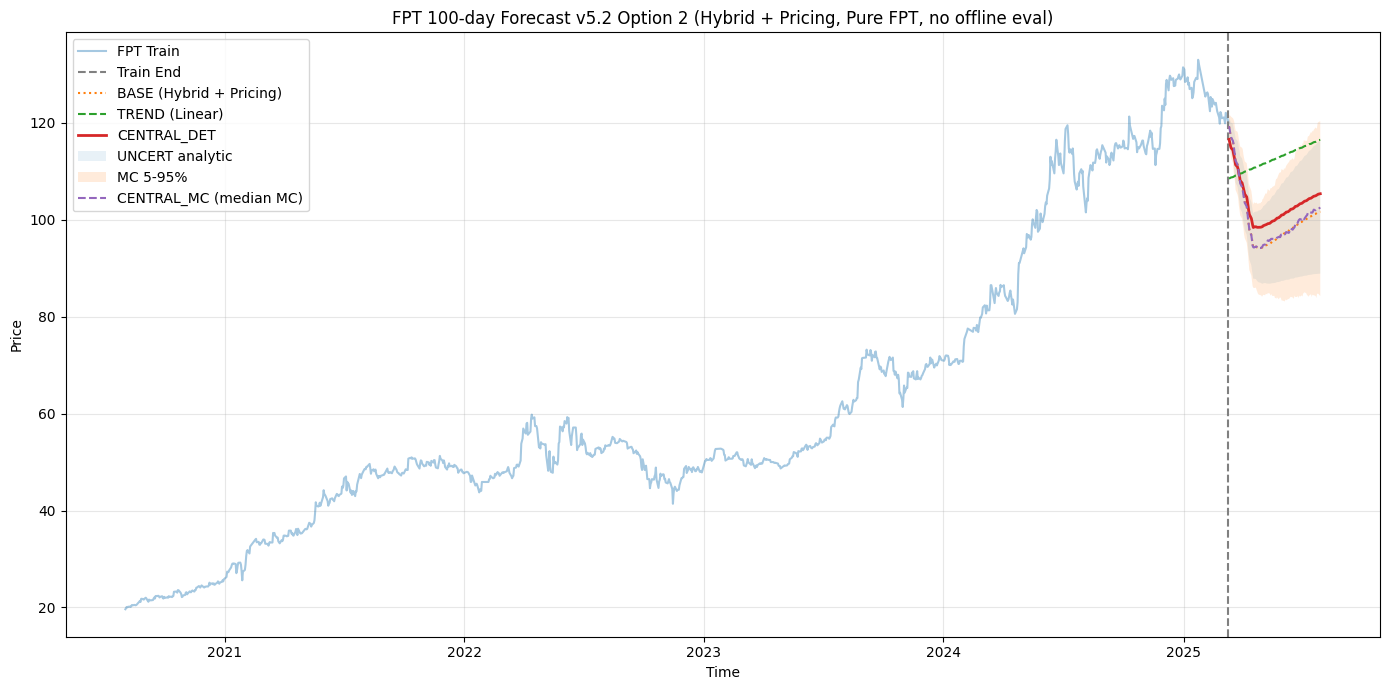

Saved FPT_forecast.csv ✅
Saved submission.csv ✅


In [19]:
if __name__ == "__main__":
    main()